### Importação e bibliotecas


In [1]:
!pip install numpy==1.23.5
import numpy as np
print(np.__version__)

1.23.5


In [2]:
!pip install yfinance
!pip install --upgrade -q mplfinance
!pip install yahoo_fin
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=df7c8d0f5ae6628a6abdf0db46fa289197d13f42f13f9baaf605167297da4e40
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=d3e80eaada167af7e8491a0735f9ce6cd75893bb20d70c01dfe7b465626e4abd
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Succ

In [3]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import plotly.graph_objects as go
import warnings
import datetime as dt
import pandas_datareader as pdr
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2023-08-29 00:29:32--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-29 00:29:33--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-29 00:29:33--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [5]:
!pip install shap==0.41.0
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.42.1
    Uninstalling shap-0.42.1:
      Successfully uninstalled shap-0.42.1




---


---
# Previsão de Fechamento com LSTM


Tentaremos prever o fechamento, com base nisso, usaremos esses valores no modelo de tendência, para extrapolar a tendência futura.

Talvez o uso de 2 modelos diferentes prejudique a previsão, mas testaremos a hipótese mesmo assim.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, Attention
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  train_test_split

 ### Coleta de dados

In [ ]:
data = yf.download(tickers = "PETR3.SA" , interval = "1d", start= "2018-02-02", end = dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data['Date'] = pd.to_datetime(data.index, format = '%Y%m%d')

## **Separação treino, teste e validação (Normalizado)**

In [ ]:
# Considerando apenas o preço de fechamento
days_time_step = 15
def ttv(df): # ttv = Teste, Treino e Validação
    df_features = df[['Date', 'Close']]
    df_features.drop('Date', axis = 1, inplace = True)

    training_size = int(len(df_features) * 0.8)
    test_size = len(df_features) - training_size

    # Normalização
    scaler = StandardScaler()
    prices_sc = scaler.fit_transform(df_features)

    train_data = prices_sc[:training_size]
    test_data = prices_sc[training_size: training_size + test_size]
    val_data = prices_sc[training_size - days_time_step:]

    #return train_data, test_data

    return train_data, test_data, val_data, scaler


## **Geração do treino, teste e validação**

In [ ]:
# Formatação para LSTM
def create_df(df, steps=1):
  dataX, dataY = [], []
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(df[i + steps, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
def Processing(train_data, test_data, val_data, days_time_step):
    #treino
    X_train, Y_train = create_df(train_data, days_time_step)
    X_test, Y_test = create_df(test_data, days_time_step)
    X_val, Y_val = create_df(val_data, days_time_step)

    #converter tudo pra matriz numpy

    X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test= X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    X_val= X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    return X_train, Y_train, X_test, Y_test, X_val, Y_val

## **Rede Neural LSTM**


### Modelo

In [ ]:
def lstm(days_time_step):
    model = Sequential()
    model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
    model.add(Dropout(0.2))
    #model.add(Attention())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model

In [ ]:
def validation(model, X_train, Y_train, X_val, Y_val):
    val = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 50, batch_size = 32, verbose = 2)
    return val

In [ ]:
def plot_val(validation):
    plt.plot(validation.history["loss"], label='loss')
    plt.plot(validation.history["val_loss"], label='val_loss')
    plt.legend()

In [ ]:
#predição de valores pela rede

def pred(model, X_test, test_data, scaler):
    predict = model.predict(X_test)

    #transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
    predict = scaler.inverse_transform(predict)
    real = scaler.inverse_transform(test_data)
    return predict, real

In [ ]:
def plot_pred(predict, real, df_t):
    plt.figure(figsize = (18,9))
    plt.plot(real, color = 'green', label = 'real')
    plt.plot(predict, color = 'red', label = 'previsão')
    plt.xticks(range(0, len(real), 50), df_t['Date'], rotation=45)
    plt.xlabel('Datas', fontsize=18)
    plt.ylabel('Preço Médio', fontsize=18)
    plt.title("Projeção de Preço AAPL", fontsize=30)
    plt.legend()
    plt.show()

### Previsão Próximos dias


In [ ]:
def last_days(test_data, days_time_step):
    lenght_test = len(test_data)
    days_input_steps = lenght_test - days_time_step

    input_steps = test_data[days_input_steps:]
    input_steps = np.array(input_steps).reshape(1,-1)

    # Transformar em lista
    list_output_steps = list(input_steps)
    list_output_steps = list_output_steps[0].tolist()

    return list_output_steps, input_steps


In [ ]:
def forecast(f_days, input_steps, list_output_steps, days_time_step, pred, model):
    pred_output = []
    i = 0
    n_future = f_days
    while (i < n_future):

      if(len(list_output_steps) > days_time_step):

        input_steps = np.array(list_output_steps[1:])
        print('{} dia. valores de entrada -> {}'.format(i, input_steps))
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape((1, days_time_step, 1))
        # print(imput_steps)
        pred = model.predict(input_steps, verbose = 0)
        print('{} dia. valores previsto -> {}'.format(i, pred))
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        # print (list_output_steps)
        pred_output.extend(pred.tolist())
        i = i + 1
      else:
        input_steps = input_steps.reshape((1, days_time_step, 1))
        pred = model.predict(input_steps, verbose = 0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i = i + 1

        print(pred_output)

    return pred_output

In [ ]:
def tf_forecast(pred_output, scaler):
    # Transforma a saída
    prev = scaler.inverse_transform(pred_output)
    prev = np.array(prev).reshape(1, -1)
    list_output_prev = list(prev)
    list_output_prev = prev[0].tolist()

    print(list_output_prev)

    return list_output_prev

In [ ]:
# Formata a saida e cria DataFrame
def format_forecast(df, list_output_prev, f_days):
    dates = pd.to_datetime(df['Date'])
    predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods = f_days, freq = 'b').tolist()
    predict_dates

    forecast_dates = []
    for i in predict_dates:
      forecast_dates.append(i.date())

    df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Close': list_output_prev})
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

    df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['Date'].values))
    df_forecast.drop('Date', axis = 1, inplace= True)

    #print(df_forecast)

    """

    # Cria uma lista de 10 datas úteis a partir da última data no DataFrame original
    predict_dates = pd.date_range(df['Date'].iloc[-1] + pd.DateOffset(1), periods=10, freq='b').date.tolist()

    # Cria um DataFrame com as datas previstas e os valores previstos
    df_forecast = pd.DataFrame({'Date': predict_dates, 'Close': list_output_prev})
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
    df_forecast.set_index('Date', inplace=True)
    """

    return df_forecast


In [ ]:
def plot_forecast(df, df_forecast):
    # Plotar gráfico
    ma100 = df.rolling(10).mean()
    plt.figure( figsize = (16,8))
    plt.plot(df['Close'])
    plt.plot(df_forecast['Close'],'r')
    plt.legend(['Preço fechamento', 'Preço Previsto'])
    #plt.plot(ma100, 'r')
    plt.show()

### Main


In [ ]:
# Função Final
def main():
    pass
    """
    days_time_step = 15
    f_days = 10
    name, start, end = call()
    df = get_ac(name, start, end)
    df = parse_date(df)

    train_data, test_data, val_data,scaler = ttv(df)

    X_train, Y_train, X_test, Y_test, X_val, Y_val = Processing(train_data, test_data, val_data, days_time_step)

    model = lstm(days_time_step)

    val = validation(model, X_train, Y_train, X_val, Y_val)

    plot_val(val)

    # Formatação

    predict, real = pred(model, X_test, test_data, scaler)

    plot_pred(predict, real, df)

    # Previsão Próximos dias

    list_output_steps, input_steps = last_days(test_data, days_time_step)

    pred_output = forecast(f_days, input_steps, list_output_steps, days_time_step, pred, model)

    list_output_prev = tf_forecast(pred_output, scaler)

    df_forecast = format_forecast(df, list_output_prev)

    plot_forecast(df, df_forecast)
    """



## **Teste**

 Coleta de dados

In [ ]:
data = yf.download(tickers = "PETR3.SA" , interval = "1d", start= "2018-02-02", end = dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data['Date'] = pd.to_datetime(data.index, format = '%Y%m%d')

In [ ]:
train_data, test_data, val_data, scaler = ttv(data)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = Processing(train_data, test_data, val_data, days_time_step)

In [ ]:
model = lstm(days_time_step)

In [ ]:
val = validation(model, X_train, Y_train, X_val, Y_val)

Epoch 1/50
34/34 - 8s - loss: 0.2923 - val_loss: 0.1170 - 8s/epoch - 231ms/step
Epoch 2/50
34/34 - 1s - loss: 0.0818 - val_loss: 0.1022 - 915ms/epoch - 27ms/step
Epoch 3/50
34/34 - 1s - loss: 0.0665 - val_loss: 0.0963 - 1s/epoch - 36ms/step
Epoch 4/50
34/34 - 1s - loss: 0.0595 - val_loss: 0.0908 - 1s/epoch - 31ms/step
Epoch 5/50
34/34 - 1s - loss: 0.0561 - val_loss: 0.0830 - 1s/epoch - 33ms/step
Epoch 6/50
34/34 - 1s - loss: 0.0531 - val_loss: 0.0782 - 1s/epoch - 32ms/step
Epoch 7/50
34/34 - 2s - loss: 0.0501 - val_loss: 0.0719 - 2s/epoch - 48ms/step
Epoch 8/50
34/34 - 2s - loss: 0.0502 - val_loss: 0.0689 - 2s/epoch - 53ms/step
Epoch 9/50
34/34 - 1s - loss: 0.0442 - val_loss: 0.0641 - 1s/epoch - 44ms/step
Epoch 10/50
34/34 - 2s - loss: 0.0434 - val_loss: 0.0625 - 2s/epoch - 46ms/step
Epoch 11/50
34/34 - 2s - loss: 0.0428 - val_loss: 0.0602 - 2s/epoch - 47ms/step
Epoch 12/50
34/34 - 1s - loss: 0.0422 - val_loss: 0.0552 - 1s/epoch - 40ms/step
Epoch 13/50
34/34 - 1s - loss: 0.0399 - val_l

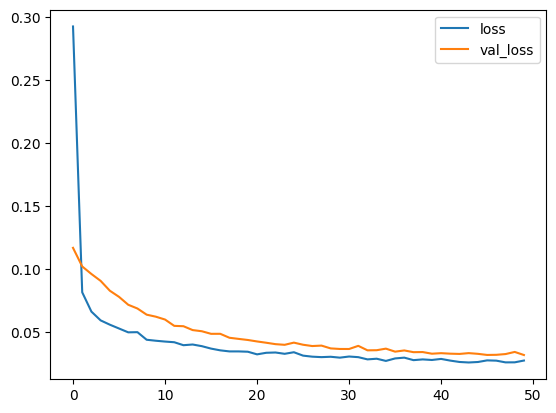

In [ ]:
plot_val(val)

In [ ]:
predict, real = pred(model, X_test, test_data, scaler)


9/9 [==============================] - 1s 6ms/step


[1.4178485]
16
[[1.4178484678268433]]
1 dia. valores de entrada -> [1.01030432 1.00635612 1.08138386 1.07940977 1.08335871 1.11494954
 1.1011286  1.2965966  1.24526179 1.28475051 1.21761991 1.08928176
 1.46639758 1.44862769 1.41784847]
1 dia. valores previsto -> [[1.3937956]]
2 dia. valores de entrada -> [1.00635612 1.08138386 1.07940977 1.08335871 1.11494954 1.1011286
 1.2965966  1.24526179 1.28475051 1.21761991 1.08928176 1.46639758
 1.44862769 1.41784847 1.39379561]
2 dia. valores previsto -> [[1.3597864]]
3 dia. valores de entrada -> [1.08138386 1.07940977 1.08335871 1.11494954 1.1011286  1.2965966
 1.24526179 1.28475051 1.21761991 1.08928176 1.46639758 1.44862769
 1.41784847 1.39379561 1.35978639]
3 dia. valores previsto -> [[1.3270705]]
4 dia. valores de entrada -> [1.07940977 1.08335871 1.11494954 1.1011286  1.2965966  1.24526179
 1.28475051 1.21761991 1.08928176 1.46639758 1.44862769 1.41784847
 1.39379561 1.35978639 1.32707047]
4 dia. valores previsto -> [[1.297828]]
5 dia. va

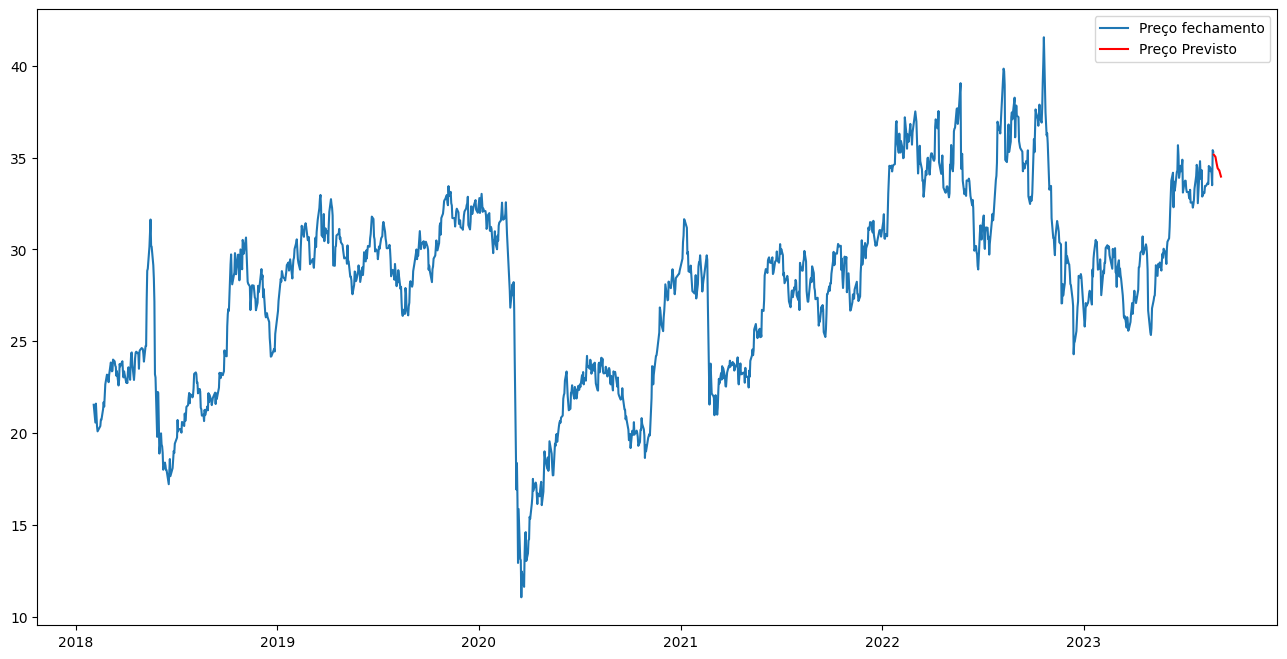

In [ ]:
# Previsão Próximos dias
f_days = 10
list_output_steps, input_steps = last_days(test_data, days_time_step)

pred_output = forecast(f_days, input_steps, list_output_steps, days_time_step, pred, model)

list_output_prev = tf_forecast(pred_output, scaler)

df_f = format_forecast(data, list_output_prev, f_days)

plot_forecast(data, df_f)



### ---





---


---
# Previsão de têndencia com base nos indicadores

Treina um modelo para calcular tendência com base nos indicadores

---
## Funções dos Indicadores Técnicos e suas tendências

A função deve receber um dataframe e um período, então calculo o indicador e devolve a tendência

Sugestões de indicaores:
- Média Móvel Simples (SMA) de diferentes períodos ✓
- Média Móvel Exponencial (EMA) de diferentes períodos ✓
- Índice de Força Relativa (RSI) ✓
- Bandas de Bollinger ✓
- MACD (Moving Average Convergence Divergence)✓
- Estocástico ✓
- Volume ✓
- Oscilador Chaikin ✓
- Fibonacci Retracement

### Return ✓

In [22]:
def get_RETURN(df):
    retorno = df['Close'].pct_change() * 100

    trend = 0 * retorno
    trend[ retorno > 0.2 ] = 1
    trend[ retorno < -0.2] = -1

    return pd.DataFrame({'return': retorno.round(2), 'return_t': trend})

### Simple Moving Average (SMA) ✓

In [23]:
def get_SMA(df, window):
    sma = df['Close'].rolling(window).mean()

    trend = 0 * sma
    trend[ df['Close'] > sma] = 1
    trend[ df['Close'] < sma] = -1

    return pd.DataFrame({f'sma_{window}': sma.round(2), f'sma_{window}_t': trend})

### Exponential Moving Average (EMA) ✓

In [24]:
def get_EMA(df, window):
    close = df['Close']
    ema = df['Close'].ewm(span=window, adjust=False).mean()

    trend = 0 * ema
    trend[ close > ema] = 1
    trend[ close < ema] = -1

    return pd.DataFrame({f'ema_{window}': ema.round(2), f'ema_{window}_t': trend})

### Relative Strength Index (RSI) ✓

In [25]:
def get_RSI(df, window = 14):
    sma = df['Close'].rolling(window).mean()
    rsi = talib.RSI(df['Close'].values, timeperiod=window)

    trend = 0 * sma
    trend[rsi < 30] = 1
    trend[rsi > 70] = -1


    return pd.DataFrame({'rsi': rsi.round(2), 'rsi_t': trend})

### Bollinger Bands (BOL) ✓

In [26]:
def get_BOL(df, window = 20, n_std = 2):
    # Cálculo das bandas de Bollinger
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * n_std)
    lower_band = rolling_mean - (rolling_std * n_std)

    # Identificação da tendência
    """
    trend = []
    for i in range(len(df)):
        if df['Close'][i] > upper_band[i]:
            trend.append(1)  # Tendência de alta
        elif df['Close'][i] < lower_band[i]:
            trend.append(-1)  # Tendência de baixa
        else:
            trend.append(0)  # Sem tendência definida
    """

    trend = rolling_mean * 0
    trend[df['Close'] > upper_band] = 1
    trend[df['Close'] < lower_band] = -1
    trend[(df['Close'] < upper_band) & (df['Close'] > lower_band)] = 0

    # Criação de um novo dataframe com a coluna "tendencia"
    df_trend = pd.DataFrame({ 'bol_t': trend})
    return df_trend


### Moving Average Convergence Divergence (MACD) ✓

In [27]:
def get_MACD(df, fast=12, slow=26, signal=9):
    exp1 = df['Adj Close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['Adj Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line

    trend = 0 * macd
    trend[macd > signal_line] = 1
    trend[macd < signal_line] = -1

    return pd.DataFrame({'macd': macd.round(2), 'macd_t': trend})

### Stochastic Oscillators (STOC) ✓

In [28]:
def get_STOC(df, janela=14, suavizacao=3, sobrevenda=20, sobrecompra=80):
    # Cálculo das linhas %K e %D
    high_n = df['High'].rolling(window=janela).max()
    low_n = df['Low'].rolling(window=janela).min()
    k_percent = 100 * ((df['Close'] - low_n) / (high_n - low_n))
    d_percent = k_percent.rolling(window=suavizacao).mean()

    # Identificação da tendência
    tendencia = []
    for i in range(len(df)):
        if k_percent.iloc[i] < sobrevenda and d_percent.iloc[i] < sobrevenda and k_percent.iloc[i] > d_percent.iloc[i]:
            tendencia.append(1)  # Tendência de alta
        elif k_percent.iloc[i] > sobrecompra and d_percent.iloc[i] > sobrecompra and k_percent.iloc[i] < d_percent.iloc[i]:
            tendencia.append(-1)  # Tendência de baixa
        else:
            tendencia.append(0)  # Tendência neutra

    return pd.DataFrame(tendencia, index=df.index, columns=['stoc_t'])


### **Oscilador Chaikin (CHAI) ✓

In [29]:
def get_CHAI(df):
    money_flow_multiplier = 2 * ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    money_flow_volume = money_flow_multiplier * df['Volume']
    adl = money_flow_volume.cumsum()
    chaikin = pd.DataFrame({'chai': adl.ewm(span=3, adjust=False).mean() - adl.ewm(span=10, adjust=False).mean()})
    chaikin['chai_t'] = chaikin['chai'].apply(lambda x: 1 if x > 0 else -1)

    return chaikin

### **Average Directional Index (ADX) ✓

In [30]:
def get_ADX(data, adx_period=14, adx_threshold=25):

    df = data.copy()
    # Calcula o True Range (TR) para cada dia
    df['TR'] = np.nan
    df['TR'] = np.maximum(df['High'] - df['Low'], df['High'] - df['Close'].shift(1))
    df['TR'] = np.maximum(df['TR'], df['Close'].shift(1) - df['Low'])

    # Calcula o Directional Movement (DM) para cada dia
    df['DMplus'] = np.nan
    df['DMminus'] = np.nan
    df['DMplus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                            df['High'] - df['High'].shift(1), 0)
    df['DMminus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                             df['Low'].shift(1) - df['Low'], 0)

    # Calcula o True Directional Indicator (DI) para cada dia
    df['DIplus'] = np.nan
    df['DIminus'] = np.nan
    df['DIplus'] = 100 * (df['DMplus'].rolling(window=14).sum() / df['TR'].rolling(window = adx_period).sum())
    df['DIminus'] = 100 * (df['DMminus'].rolling(window=14).sum() / df['TR'].rolling(window = adx_period).sum())

    # Calcula o Average Directional Index (ADX) para cada dia
    df['DX'] = np.nan
    df['DX'] = 100 * np.abs((df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']))
    df['adx'] = np.nan
    df['adx'] = df['DX'].rolling(window=14).mean()

    #########################################################

    adx = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=adx_period)
    plus_di = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=adx_period)
    minus_di = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=adx_period)

    df['adx'] = adx
    df['PlusDI'] = plus_di
    df['MinusDI'] = minus_di

    df.loc[(adx > adx_threshold) & (plus_di > minus_di), 'adx_t'] = 1
    df.loc[(adx > adx_threshold) & (plus_di < minus_di), 'adx_t'] = -1
    df.loc[adx <= adx_threshold, 'adx_t'] = 0

    return df[['adx',  'adx_t']]



---
## Dados


### Coleta

In [31]:
def get_ac(ativo, start, end, intervalo = '1d'):
  df = yf.download(tickers=ativo, interval=intervalo, start=start, end=end)
  return df

In [32]:
data = get_ac("PETR3.SA" , "2021-02-02", dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [33]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-02,28.889999,29.809999,28.690001,29.080000,11.962841,22197200
2021-02-03,29.350000,29.580000,29.070000,29.299999,12.053344,18113900
2021-02-04,29.280001,29.450001,28.750000,29.270000,12.041001,9732200
2021-02-05,29.309999,30.709999,29.010000,29.680000,12.209664,29591900
2021-02-08,29.170000,29.840000,28.150000,28.450001,11.703673,30213000
...,...,...,...,...,...,...
2023-08-22,33.270000,33.540001,33.130001,33.500000,33.500000,7482700
2023-08-23,34.070000,35.419998,34.070000,35.410000,35.410000,26164500
2023-08-24,35.320000,35.840000,35.070000,35.320000,35.320000,8234700


### Indicadores

In [34]:
ema10_df = get_EMA(data, 10)
sma10_df = get_SMA(data, 10)
ema5_df = get_EMA(data, 5)
sma5_df = get_SMA(data, 5)
stoc_df = get_STOC(data)
bol_df = get_BOL(data)
adx_df = get_ADX(data)
chai_df = get_CHAI(data)

rsi_df = get_RSI(data, 14)
macd_df = get_MACD(data)
return_df = get_RETURN(data)

### Merge


In [35]:
data = data.join([rsi_df, sma10_df, ema10_df, sma5_df, ema5_df, macd_df, return_df, stoc_df, bol_df, adx_df, chai_df])

In [36]:
trend_df = pd.concat([rsi_df, sma10_df, ema10_df, sma5_df, ema5_df, macd_df, return_df, stoc_df, bol_df, adx_df, chai_df])

In [38]:
#data_c = data.iloc[:-(f_days)].copy() # Cria DataFrame sem as datas futuras

In [39]:
#data_f = data.iloc[-(f_days):].copy() # Cria DataFrame somente com as daats futuras

### Tratamento

In [40]:
data.dropna(inplace=True)

In [41]:
# Rastreadores
data['sma_5_t'] = data['sma_5_t'].astype(int)
data['ema_5_t'] = data['ema_5_t'].astype(int)
data['sma_10_t'] = data['sma_10_t'].astype(int)
data['ema_10_t'] = data['ema_10_t'].astype(int)
data['macd_t'] = data['macd_t'].astype(int)

# Osciladores
data['chai_t'] = data['chai_t'].astype(int) # ?
data['stoc_t'] = data['stoc_t'].astype(int)
data['adx_t'] = data['adx_t'].astype(int) # ?
data['rsi_t'] = data['rsi_t'].astype(int)

# Indicadores de Volatilidade
data['bol_t'] = data['bol_t'].astype(int)

# Tendência real
data['return_t'] = data['return_t'].astype(int)

In [42]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,rsi,rsi_t,sma_10,sma_10_t,...,macd,macd_t,return,return_t,stoc_t,bol_t,adx,adx_t,chai,chai_t
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-22,33.270000,33.540001,33.130001,33.500000,33.500000,7482700,48.91,0,33.86,-1,...,0.33,1,-1.90,-1,0,0,14.849736,0,-2.656968e+06,-1
2023-08-23,34.070000,35.419998,34.070000,35.410000,35.410000,26164500,61.41,0,34.05,1,...,0.50,1,5.70,1,0,1,16.132328,0,1.526016e+07,1
2023-08-24,35.320000,35.840000,35.070000,35.320000,35.320000,8234700,60.66,0,34.24,1,...,0.63,1,-0.25,-1,0,0,17.587061,0,1.936511e+07,1
2023-08-25,35.419998,35.680000,34.720001,35.040001,35.040001,13843300,58.26,0,34.39,1,...,0.70,1,-0.79,-1,0,0,18.479646,0,1.634749e+07,1
2023-08-28,0.000000,0.000000,0.000000,35.400002,35.400002,0,60.43,0,34.57,1,...,0.77,1,1.03,1,0,0,22.759320,0,1.634749e+07,1


---

## Machine Learning - Random Forest

### Separação de Dados

In [43]:
Y = data['return_t']
features=['Volume', 'rsi', 'ema_5_t', 'sma_5_t', 'ema_10_t', 'sma_10_t', 'stoc_t', 'bol_t', 'adx_t', 'macd_t','macd', 'chai_t']

#features=[ 'rsi', 'ema_5_t', 'sma_5_t', 'ema_10_t', 'sma_10_t', 'bol_t']

X = data[features]

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### Melhores Hiperpâmetros

In [45]:
"""
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define a grade de possíveis valores para os hiperparâmetros
param_distribs = {
        'n_estimators': randint(low=10, high=200),
        'max_features': randint(low=1, high=3),
        'max_depth': randint(low=1, high=10),
        'min_samples_split': randint(low=2, high=10),
        'n_jobs': randint(low=2, high=10),
        'min_samples_leaf': randint(low=1, high=10)
    }

# Cria um modelo com o estimador RandomForestClassifier
rnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='accuracy', random_state=42)

# Treina o modelo com a busca aleatória dos hiperparâmetros
rnd_search.fit(x_train, y_train)

# Verifica os melhores hiperparâmetros selecionados
print(rnd_search.best_params_)


# {'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 68}
"""

"\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\nfrom scipy.stats import randint\n\n# Define a grade de possíveis valores para os hiperparâmetros\nparam_distribs = {\n        'n_estimators': randint(low=10, high=200),\n        'max_features': randint(low=1, high=3),\n        'max_depth': randint(low=1, high=10),\n        'min_samples_split': randint(low=2, high=10),\n        'n_jobs': randint(low=2, high=10),\n        'min_samples_leaf': randint(low=1, high=10)\n    }\n\n# Cria um modelo com o estimador RandomForestClassifier\nrnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_distribs,\n                                n_iter=50, cv=5, scoring='accuracy', random_state=42)\n\n# Treina o modelo com a busca aleatória dos hiperparâmetros\nrnd_search.fit(x_train, y_train)\n\n# Verifica os melhores hiperparâmetros selecionados\nprint(rnd_search.best_params_)\n\n\n# {'max_depth': 6, 

### Treinamento do modelo

In [46]:
ml_rf = RandomForestClassifier(n_estimators=11, n_jobs = 9, max_depth = 8,
                                  max_features = 1, min_samples_leaf = 6,
                                  min_samples_split = 6)
ml_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, max_features=1, min_samples_leaf=6,
                       min_samples_split=6, n_estimators=11, n_jobs=9)

In [47]:
predictions = ml_rf.predict(x_test)

### Melhores Features

In [48]:

from sklearn.feature_selection import SelectFromModel

# Substitua o nome do seu modelo e dos dados
sel = SelectFromModel(ml_rf, threshold=0.04)
sel.fit(x_train, y_train)

# Substitua o nome das suas colunas de features
selected_feat= x_train.columns[(sel.get_support())]
print(selected_feat)


Index(['Volume', 'rsi', 'ema_5_t', 'sma_5_t', 'ema_10_t', 'stoc_t', 'bol_t',
       'macd'],
      dtype='object')


### Avaliação

In [49]:
ml_rf.predict(data[features])

array([ 1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,
       -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
        1, -1, -1,  1, -1

In [50]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.73      0.76      0.75        87
           0       0.00      0.00      0.00        20
           1       0.68      0.80      0.74        96

    accuracy                           0.70       203
   macro avg       0.47      0.52      0.49       203
weighted avg       0.64      0.70      0.67       203

[[66  0 21]
 [ 5  0 15]
 [19  0 77]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


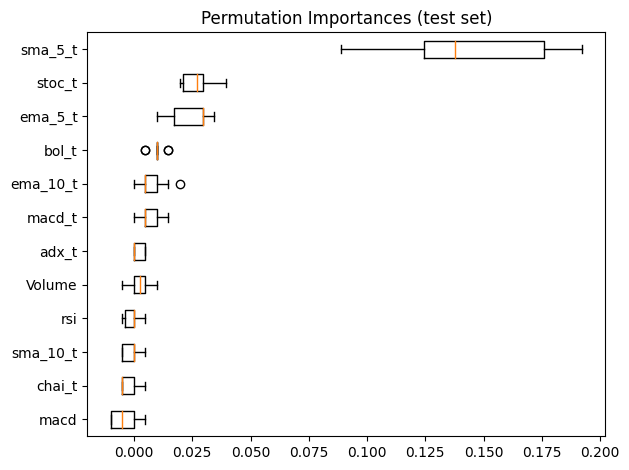

In [51]:
result = permutation_importance(ml_rf, x_test, y_test, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


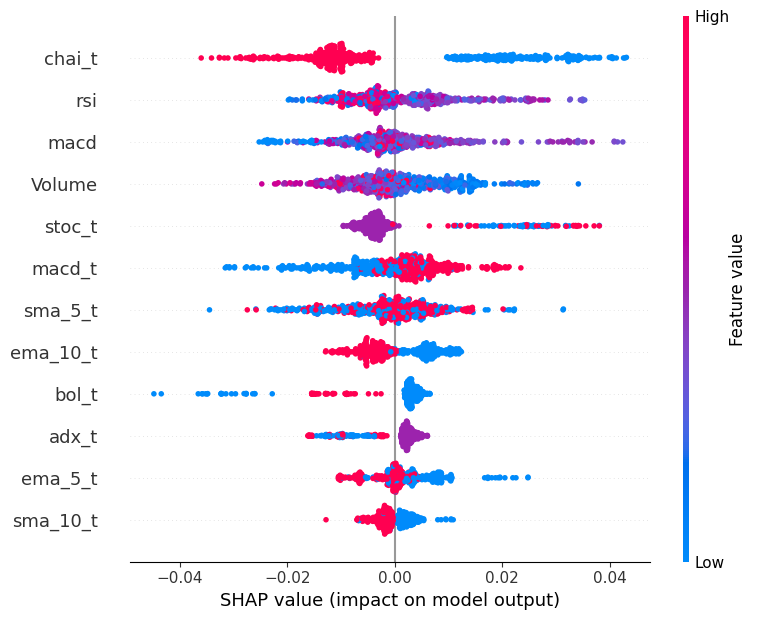

In [52]:
explainer = shap.TreeExplainer(ml_rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X)

In [53]:
n = 1
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][n], x_train.iloc[0])

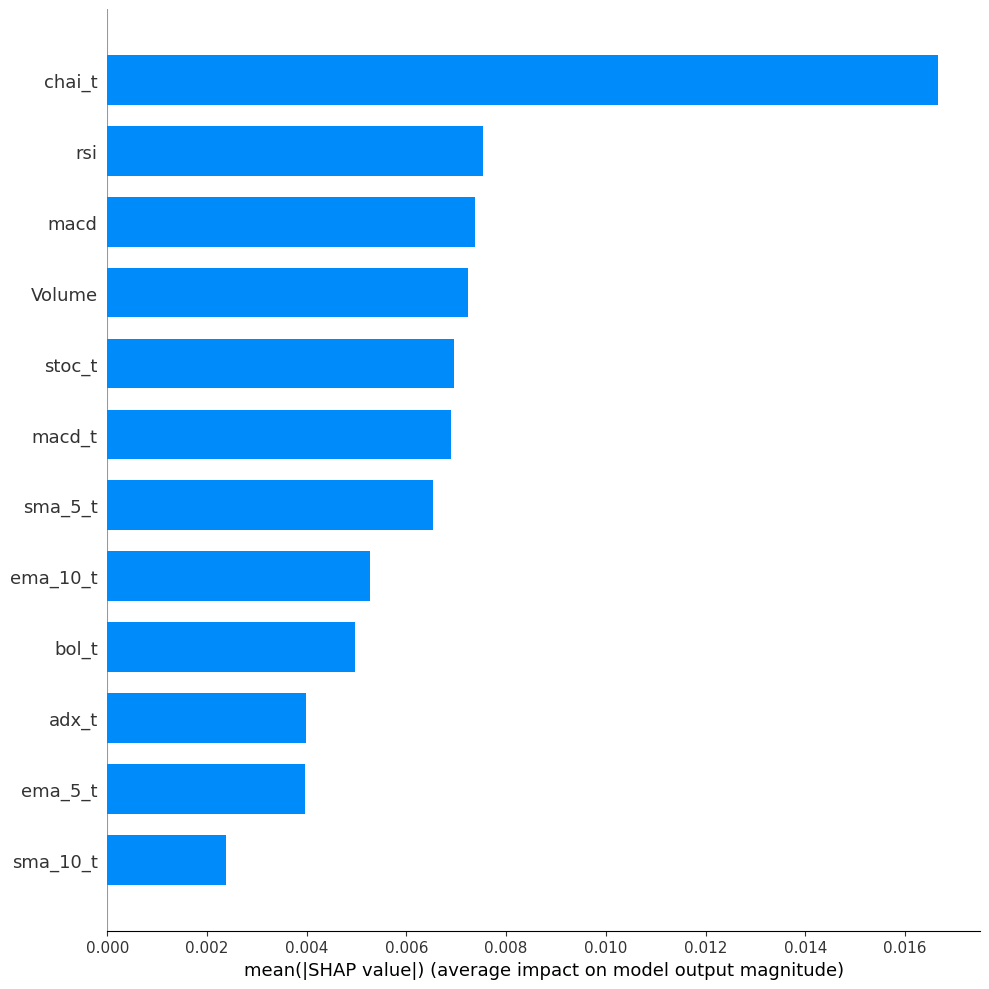

In [54]:
shap.summary_plot(shap_values[1], x_train, plot_type="bar", plot_size=(10,10));


In [59]:
teste = ['Volume', 'rsi', 'ema_5_t', 'sma_5_t', 'ema_10_t', 'sma_10_t', 'stoc_t', 'return_t', 'bol_t', 'adx_t', 'macd_t','macd', 'chai_t']

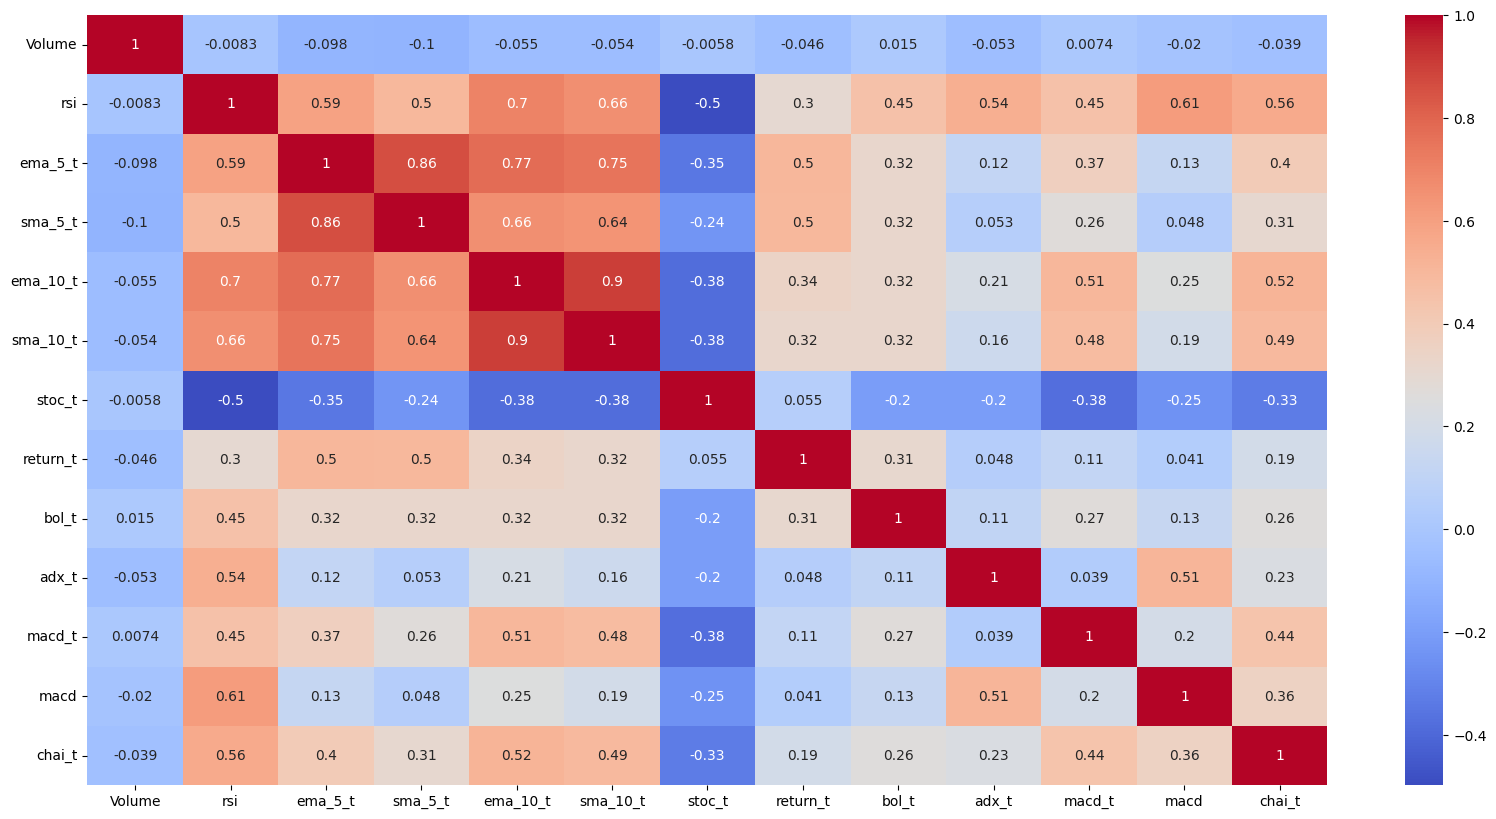

In [60]:
corr = data[teste].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

DÁ UMA OLHADA NA https://pypi.org/project/sweetviz/



---


---
# Tendência Futura
Com o modelo treinado, aplicamos ele aos dados de forecast do modelo LSTM


### Dias Futuros

In [ ]:
data_f[features]

,rsi,ema_5_t,sma_5_t,ema_10_t,sma_10_t,bol_t
2023-08-25,59.30,1.0,1.0,1.0,1.0,0.0
2023-08-28,58.21,1.0,1.0,1.0,1.0,0.0
2023-08-29,56.61,-1.0,-1.0,1.0,1.0,0.0
2023-08-30,55.05,-1.0,-1.0,1.0,1.0,0.0
2023-08-31,53.63,-1.0,-1.0,-1.0,-1.0,0.0
2023-09-01,52.32,-1.0,-1.0,-1.0,-1.0,0.0
2023-09-04,51.09,-1.0,-1.0,-1.0,-1.0,0.0
2023-09-05,49.90,-1.0,-1.0,-1.0,-1.0,0.0
2023-09-06,48.73,-1.0,-1.0,-1.0,-1.0,0.0
2023-09-07,47.56,-1.0,-1.0,-1.0,-1.0,0.0


In [ ]:
ml_rf.classes_

array([-1,  0,  1])

In [ ]:
ml_rf.predict(data_f[features])

array([ 1,  1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
proba = ml_rf.predict_proba(data_f[features])

In [ ]:
proba_df = pd.DataFrame(proba, columns=['Proba Baixa', 'Proba Nula', 'Proba Alta'])

In [ ]:
proba_df['Tendência Calc.'] = ml_rf.predict(data_f[features])

In [ ]:
proba_df = proba_df[['Tendência Calc.','Proba Baixa', 'Proba Nula', 'Proba Alta']]

In [ ]:
proba_df = proba_df.set_index(data_f.index)
proba_df

,Tendência Calc.,Proba Baixa,Proba Nula,Proba Alta
2023-08-25,1,0.184002,0.062386,0.753612
2023-08-28,1,0.177942,0.062386,0.759673
2023-08-29,-1,0.957537,0.012094,0.030369
2023-08-30,-1,0.941008,0.012094,0.046898
2023-08-31,-1,0.638576,0.067127,0.294297
2023-09-01,-1,0.591955,0.067127,0.340917
2023-09-04,-1,0.583443,0.099192,0.317365
2023-09-05,-1,0.620633,0.089550,0.289817
2023-09-06,-1,0.637449,0.081059,0.281492
2023-09-07,-1,0.644259,0.084795,0.270946




---


---

# Resumo
  - Pega-se os dados do ativo financeiro;
  - Com o modelo LSTM, é feito o Forecast do fechamento para **n dias futuros**;
  - Tais dados são adicionados aos dados originais para calcular os indicadores sem problema de falta de dados;
  - Após os calculos dos indicadores, separa-se os dados entre os atuais e futuros;
  - Treina-se o modelo de Random Forest com os dados até a atualidade;
  - O modelo treinado é aplicado aos dados futuros gerados pelo LSTM;
  - Obtém-se a tendência de **n dias futuros** e suas probabilidades

# Observação importante:
 - A probabilidade final mostrada é referente a probabilidade da tendência, porém não leva em conta a variança do fechamento gerado pelo LSTM. Sendo assim, aquelas probabilidades distoam da probabilidade real de se obter aquela tendência.

# Conclusão

- Deu certo, só não sei ao certo como testar a precisão desses valores tendo em vista que o fechamento foi por forecast e depois eu apliquei outro modelo em cima;

- Por não ter os dados de Volume, Máximo e Mínimo, acaba que alguns indicadores perderam a utilidade, isso pode acabar tendo um impacto final negativo, pois reduz informações que poderiam ser úteis;
- Não sei ao certo como calcular o impact das 2 conclusões anteriores.



---
# Estratégia de Compra e venda

Voltado para a estratégia de compra e venda, seria interessante usar esses dados para treinar um modelo que reconheça a melhor estratégia, ignorando a tendência e focando apenas no retorno monetário.

### RSI

In [ ]:
# Estratégia
def Est_RSI(df, window = 14, up_exit = 70, down_entry = 30, bet_size = 10):
    dict_trades = []
    t = 0
    for idx, row in df.iterrows():
        if row['rsi'] <= down_entry and t == 0:
            dict_trades += [{'price': row['Close'], 'time': idx, 'kind': 'buy', 'quantity': bet_size}]
            t = 1

        elif row['rsi'] > up_exit and t == 1:
            dict_trades += [{'price': row['Close'], 'time': idx, 'kind': 'sell', 'quantity': -bet_size}]
            t = 0

    df_trades_raw = pd.DataFrame(dict_trades).set_index('time')
    df_buys = df_trades_raw[df_trades_raw['kind'] == 'buy']
    df_sells = df_trades_raw[df_trades_raw['kind'] == 'sell']

    df_trades = df_trades_raw.join(data["Close"], how='outer')

    df_trades["position"] = df_trades["quantity"].shift(1).fillna(0).cumsum()

    df_trades["ret_market"] = df_trades["Close"] - df_trades["Close"].shift(1)
    df_trades["ret"] = df_trades["ret_market"] * df_trades["position"]
    df_trades["ret_cum"] = df_trades["ret"].cumsum()

    #return df_trades["ret_cum"].plot()

    return df_buys, df_sells, df_trades

In [ ]:
df_buys, df_sells, df_trades = Est_RSI(data)

In [ ]:
df_trades

,price,kind,quantity,Close,position,ret_market,ret,ret_cum
2018-03-15,NaN,NaN,NaN,23.120001,0.0,NaN,NaN,NaN
2018-03-16,NaN,NaN,NaN,23.370001,0.0,0.250000,0.0,0.000000
2018-03-19,NaN,NaN,NaN,22.590000,0.0,-0.780001,-0.0,0.000000
2018-03-20,NaN,NaN,NaN,22.889999,0.0,0.299999,0.0,0.000000
2018-03-21,NaN,NaN,NaN,23.760000,0.0,0.870001,0.0,0.000000
...,...,...,...,...,...,...,...,...
2023-08-18,NaN,NaN,NaN,34.490002,0.0,0.200001,0.0,194.699974
2023-08-21,NaN,NaN,NaN,34.150002,0.0,-0.340000,-0.0,194.699974
2023-08-22,NaN,NaN,NaN,33.500000,0.0,-0.650002,-0.0,194.699974
2023-08-23,NaN,NaN,NaN,35.410000,0.0,1.910000,0.0,194.699974


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, row_heights=[0.6, 0.2, 0.2], vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']), row=1, col=1)

fig.add_trace(go.Scatter(x=df_buys.index,y=df_buys['price'], marker_color='#11dd11',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-up'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_sells.index,y=df_sells['price'], marker_color='#dd2222',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-down'), row=1, col=1)

fig.add_trace(go.Scatter(x=data.index,
                y=df_trades['ret_cum']), row=2, col=1)

fig.add_trace(go.Scatter(x=data.index,
                y=data['rsi']), row=3, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

### SMA e EMA

In [ ]:
def Est_MA(data, kind, window = 50, bet_size = 10):
    dict_trades = []
    t = 0
    df = data.copy()
    kind = str(kind)
    #df["SMA"] = df["Close"].rolling(window=window).mean()
    if f"{kind}_{window}" in df.columns:
      for idx, row in df.iterrows():
        if row["Close"] > row[f"{kind}_{window}"] and t == 0:
              dict_trades += [{'price': row['Close'], 'time': idx, 'kind': 'buy', 'quantity': bet_size}]
              t = 1

        elif row["Close"] < row[f"{kind}_{window}"] and t == 1:
              dict_trades += [{'price': row['Close'], 'time': idx, 'kind': 'sell', 'quantity': -bet_size}]
              t = 0

      df_trades_raw = pd.DataFrame(dict_trades).set_index('time')
      df_buys = df_trades_raw[df_trades_raw['kind'] == 'buy']
      df_sells = df_trades_raw[df_trades_raw['kind'] == 'sell']

      df_trades = df_trades_raw.join(df["Close"], how='outer')

      df_trades["position"] = df_trades["quantity"].shift(1).fillna(0).cumsum()

      df_trades["ret_market"] = df_trades["Close"] - df_trades["Close"].shift(1)
      df_trades["ret"] = df_trades["ret_market"] * df_trades["position"]
      df_trades["ret_cum"] = df_trades["ret"].cumsum()

      return df_trades["ret_cum"].plot()

    else:
      print(f"There is no Simple Moving Average with a window of {window}")


<Axes: >

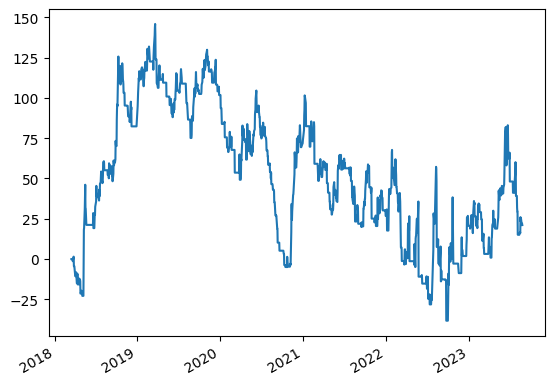

In [ ]:
Est_MA(data, "ema", 5)